In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, confusion_matrix, classification_report
import lightgbm as lgb
import re
from time import time
import pprint

In [2]:
df = pd.read_csv('data1/data1.csv')
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [3]:
## Dataset is a little unbalanced, will consider it when building the model
df['status'].value_counts(normalize=True)

0    0.753846
1    0.246154
Name: status, dtype: float64

In [4]:
df.head()

,name,status,MDVPFoHz,MDVPFhiHz,MDVPFloHz,MDVPJitter,MDVPJitterAbs,MDVPRAP,MDVPPPQ,JitterDDP,...,new5,new6,new7,new8,new9,new10,new11,new12,new13,new14
0,phon_R01_S01_1,0,46.998609,28.710891,13.977771,49.898348,63.498024,37.095376,63.135048,37.048483,...,17.069596,32.169278,28.771138,34.688030,36.570776,16.639018,34.672864,10.687196,38.919785,0.0
1,phon_R01_S01_2,0,50.573347,24.207263,70.972313,64.803050,73.577075,48.764451,82.540193,48.715685,...,38.750095,81.205263,76.110354,88.561299,91.795482,47.736975,88.561858,14.439213,65.123116,0.0
2,phon_R01_S01_3,0,42.084828,15.077681,67.648537,71.445362,83.656126,58.468208,94.155949,58.499759,...,45.500660,66.049353,55.054272,74.845949,75.226695,36.778094,74.826014,9.305259,70.915402,0.0
3,phon_R01_S01_4,0,42.075920,18.596467,67.371066,67.152160,83.656126,53.309249,82.813505,53.259753,...,41.318183,69.739650,59.639456,79.890200,78.317302,38.998698,79.870110,9.630110,70.709123,0.0
4,phon_R01_S01_5,0,41.093164,20.631740,66.327248,90.400254,103.814229,72.102601,111.511254,72.131963,...,55.660963,82.900076,68.126720,96.786668,95.683259,47.387074,96.776361,12.761477,65.212299,0.0


### Clean the dataset

In [5]:
(df == 0).sum()

name               0
status           147
MDVPFoHz           1
MDVPFhiHz          1
MDVPFloHz          1
MDVPJitter         1
MDVPJitterAbs      1
MDVPRAP            1
MDVPPPQ            1
JitterDDP          1
MDVPShimmer        1
MDVPShimmerdB      2
ShimmerAPQ3        1
ShimmerAPQ5        1
MDVPAPQ            1
ShimmerDDA         1
NHR                1
HNR                1
RPDE               1
DFA                1
spread1            1
spread2            1
D2                 1
PPE                1
new1               1
new2               1
new3               1
new4               1
new5               1
new6               1
new7               1
new8               1
new9               1
new10              1
new11              1
new12              1
new13              1
new14            147
dtype: int64

In [6]:
## column new14 has mostly zeros, so we can drop it.
## name column is irrelevant so we can drop it also.
df = df.drop(['new14', 'name'], axis=1)

### Split the dataset

In [7]:
y = df['status']
X = df.drop(['status'], axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, stratify=y, random_state=42)

### Train the model

In [11]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

In [12]:
### A wrapper for measuring time and performances of different optmizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [14]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=-1, 
                         verbose=-1,
                         random_state=0)

In [15]:
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),
    'n_estimators': Integer(30, 5000),
    'num_leaves': Integer(2, 512),
    'max_depth': Integer(-1, 256),
    'min_child_samples': Integer(1, 256),
    'max_bin': Integer(100, 1000),
    'subsample': Real(0.01, 1.0, 'uniform'),
    'subsample_freq': Integer(0, 10),
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),
    'min_child_weight': Real(0.01, 10.0, 'uniform'),
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),
    'scale_pos_weight': Real(1.0, 500.0, 'uniform'),
        }

In [16]:
opt = BayesSearchCV(estimator=clf,                                    
                    search_spaces=search_spaces,                      
                    scoring=roc_auc,                                  
                    cv=skf,                                           
                    n_iter=3000,
                    n_points=3,
                    n_jobs=-1,
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=0)

In [17]:
time_limit_control = DeadlineStopper(total_time=60 * 15)

best_params = report_perf(opt, X_train, y_train,'LightGBM', 
                          callbacks=[time_limit_control])

LightGBM took 895.50 seconds,  candidates checked: 177, best CV score: 0.988 ± 0.009
Best parameters:
OrderedDict([('colsample_bytree', 0.5215277629790377),
             ('learning_rate', 0.30250539639574087),
             ('max_bin', 428),
             ('max_depth', 13),
             ('min_child_samples', 12),
             ('min_child_weight', 3.757632314978091),
             ('n_estimators', 5000),
             ('num_leaves', 434),
             ('reg_alpha', 1.3710318521212446e-07),
             ('reg_lambda', 0.05342478065122868),
             ('scale_pos_weight', 368.4637695984076),
             ('subsample', 1.0),
             ('subsample_freq', 8)])



### Training a classifier with the best parameters

In [18]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params)

In [27]:
clf.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.5215277629790377,
               learning_rate=0.30250539639574087, max_bin=428, max_depth=13,
               metric='auc', min_child_samples=12,
               min_child_weight=3.757632314978091, n_estimators=5000, n_jobs=1,
               num_leaves=434, objective='binary', random_state=0,
               reg_alpha=1.3710318521212446e-07, reg_lambda=0.05342478065122868,
               scale_pos_weight=368.4637695984076, subsample_freq=8,
               verbose=-1)

### Evaluating the model

In [20]:
y_pred = clf.predict(X_test)

In [22]:
accuracy_score(y_test, y_pred)

0.8974358974358975

<IPython.core.display.Javascript object>


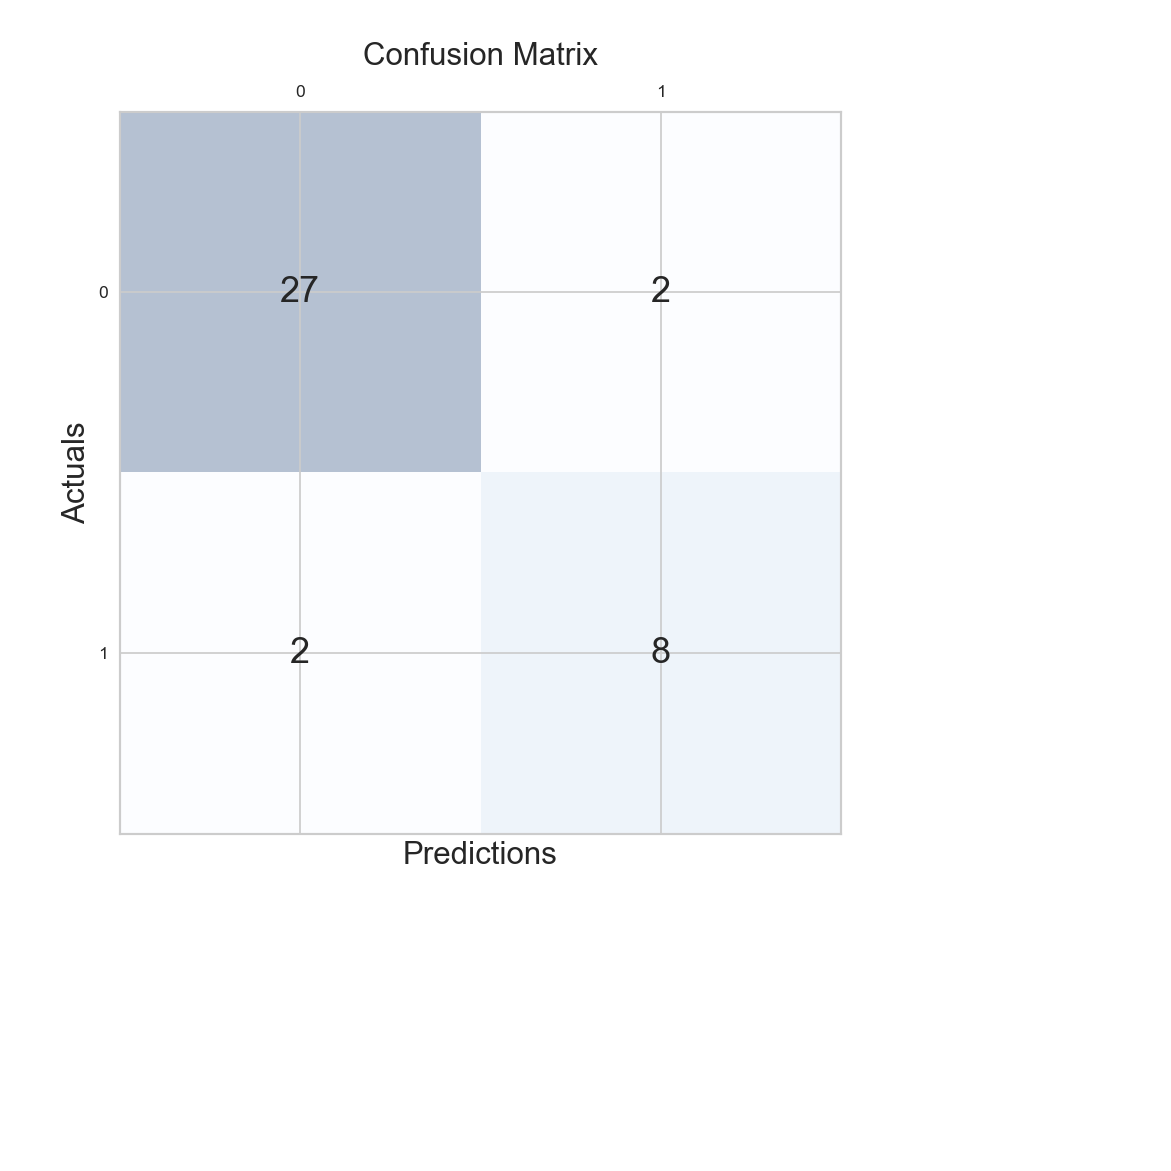

In [23]:
conf_matrix = confusion_matrix(y_test,y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Classification report

In [25]:
with open('report.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred))